In [1]:
dataset_name = "rds_cpu_utilization_cc0c53"
path = "data/" + dataset_name + ".csv"
gaussian_window_size = 1024

In [2]:
import adclasses
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import numpy as np
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


# Preprocess dataset

In [3]:
data = pd.read_csv(path, header=0)
start_date = data["timestamp"].values[0]
end_date = data["timestamp"].values[-1]
print("Start date: ", start_date)
print("End date: ", end_date)
data["timestamp"] = pd.to_datetime(data["timestamp"], format="%Y-%m-%d %H:%M:%S")

print("Missing time stamps: \n", adclasses.find_missing_time_steps(start_date, end_date, '5min', data))

# if you want to use a method that cannot take missing time steps
# into account, you need to fill in the missing time steps yourself
# this function also removes duplicates
print("Fill Missing Time Steps with Interpolation")
data = adclasses.fill_missing_time_steps(start_date, end_date, '5min', data, method="linear")

# write to csv for htm
# data.to_csv("/home/cfreeman/Desktop/prefill/" + dataset_name + ".csv", index=False)

data["timestamp"] = pd.to_datetime(data["timestamp"], format="%Y-%m-%d %H:%M:%S")
ad = adclasses.UnivariateAnomalyDetection(dataframe=data, timestep="5min", dateformat="%Y-%m-%d %H:%M:%S", name=dataset_name)
print("Length: ", ad.get_length())
print("Time step size: ", ad.get_timestep())
print("Date Format: ", ad.get_dateformat())
true_outlier_dates = ["2014-02-25 07:15:00",
                      "2014-02-27 00:50:00"]
true_outlier_indices = ad.convert_true_outlier_date(true_outlier_dates)
print("True outlier indices: ", true_outlier_indices)

Start date:  2014-02-14 14:30:00
End date:  2014-02-28 14:30:00
Missing time stamps: 
 DatetimeIndex(['2014-02-25 07:10:00'], dtype='datetime64[ns]', freq='5T')
Fill Missing Time Steps with Interpolation
Length:  4033
Time step size:  5min
Date Format:  %Y-%m-%d %H:%M:%S
True outlier indices:  [3081, 3580]


# GLM

In [4]:
# optimize
etas = [.5,1]
lambdas = [.99, .999, .9999]

opt_dict = {}

for eta in etas:
    for lambda_ in lambdas:
       
        mse = ad.glm(gaussian_window_size=gaussian_window_size, 
                     family='gaussian', 
                     eta=eta, 
                     lambda_=lambda_)["MSE"]

        print("eta: ", eta)
        print("lambda: ", lambda_)
        print("MSE: ",mse)

        key_str = "eta " + str(eta) + " lambda " + str(lambda_)

        opt_dict[key_str] = mse

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

 59%|█████▉    | 2387/4033 [00:00<00:00, 23866.78it/s]

Initial Mean 6.191179917218543
Initial StdDev 0.36675138143331315


100%|██████████| 4033/4033 [00:00<00:00, 24730.31it/s]

eta:  0.5
lambda:  0.99
MSE:  1.4363115116179872e+20
Initial Mean 6.191179917218543
Initial StdDev 0.36675138143331315



100%|██████████| 4033/4033 [00:00<00:00, 28792.26it/s]

eta:  0.5
lambda:  0.999
MSE:  6.7205651116884795
Initial Mean 6.191179917218543
Initial StdDev 0.36675138143331315



100%|██████████| 4033/4033 [00:00<00:00, 29181.28it/s]

eta:  0.5
lambda:  0.9999
MSE:  12.357969863231071
Initial Mean 6.191179917218543
Initial StdDev 0.36675138143331315



100%|██████████| 4033/4033 [00:00<00:00, 26277.36it/s]

eta:  1
lambda:  0.99
MSE:  6974300.835629061
Initial Mean 6.191179917218543
Initial StdDev 0.36675138143331315



100%|██████████| 4033/4033 [00:00<00:00, 27999.98it/s]

eta:  1
lambda:  0.999
MSE:  3.632605466303858
Initial Mean 6.191179917218543
Initial StdDev 0.36675138143331315


eta:  1
lambda:  0.9999
MSE:  9.255206102110442

best params:  eta 1 lambda 0.999


100%|██████████| 4033/4033 [00:00<00:00, 29254.96it/s]

Initial Mean 6.191179917218543
Initial StdDev 0.36675138143331315


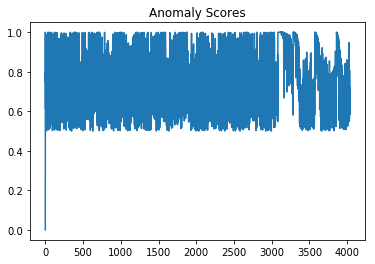

Time:  0.6556389331817627


['anomaly_scores/GLM/rds_cpu_utilization_cc0c53']

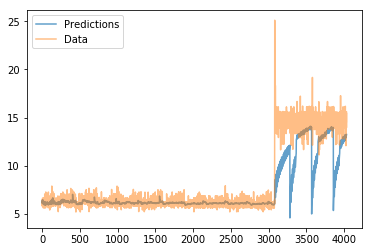

In [5]:
save_path = "anomaly_scores/GLM/" + dataset_name
output_dict = ad.glm(gaussian_window_size=gaussian_window_size, family='gaussian', 
                     eta=1, lambda_=0.999,plot_anomaly_scores=True, plot_forecast=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# SARIMA


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : Inf
 ARIMA(0,0,0) with non-zero mean : 479.9661
 ARIMA(1,0,0) with non-zero mean : 480.6518
 ARIMA(0,0,1) with non-zero mean : 480.0586
 ARIMA(0,0,0) with zero mean     : 478.5996
 ARIMA(1,0,1) with non-zero mean : Inf

 Now re-fitting the best model(s) without approximations...

 ARIMA(0,0,0) with zero mean     : 478.5996

 Best model: Regression with ARIMA(0,0,0) errors 



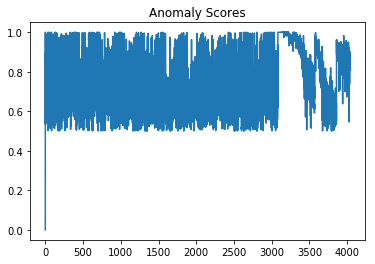

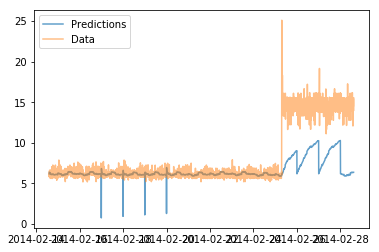

Time:  3.6781444549560547


['anomaly_scores/SARIMA_auto/rds_cpu_utilization_cc0c53']

In [6]:
save_path = "anomaly_scores/SARIMA_auto/" + dataset_name
output_dict = ad.sarimax(gaussian_window_size=gaussian_window_size, step_size=100, auto=True,
                         use_exog=True, plot_anomaly_scores=True,plot_forecast=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# FB Prophet

In [7]:
# optimization step

step_sizes = [100, 200]
changepoint_prior_scales = [.01, .05, .1, .15, .2]
opt_dict = {}

for step_size in step_sizes:
    for changepoint_prior_scale in changepoint_prior_scales:

        mse = ad.facebook_prophet(gaussian_window_size=gaussian_window_size, 
                                  changepoint_prior_scale=changepoint_prior_scale,
                                  step_size=step_size,
                                  optimize=True)
        print("Step Size: ", step_size)
        print("Changepoint Prior Scale: ", changepoint_prior_scale)
        print("MSE: ",mse)

        key_str = "Step Size " + str(step_size) +" Changepoint Prior Scale" + str(changepoint_prior_scale)

        opt_dict[key_str] = mse

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Changepoint Prior Scale:  0.01
MSE:  0.21273496781363022


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Changepoint Prior Scale:  0.05
MSE:  0.13390986128136703


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Changepoint Prior Scale:  0.1
MSE:  0.12683642251437685


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Changepoint Prior Scale:  0.15
MSE:  0.12535307173906143


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Changepoint Prior Scale:  0.2
MSE:  0.12422999197391892


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Changepoint Prior Scale:  0.01
MSE:  0.21273496781363022


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Changepoint Prior Scale:  0.05
MSE:  0.13390986128136703


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Changepoint Prior Scale:  0.1
MSE:  0.12683642251437685


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Changepoint Prior Scale:  0.15
MSE:  0.12535307173906143
Step Size:  200
Changepoint Prior Scale:  0.2
MSE:  0.12422999197391892

best params:  Step Size 100 Changepoint Prior Scale0.2


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


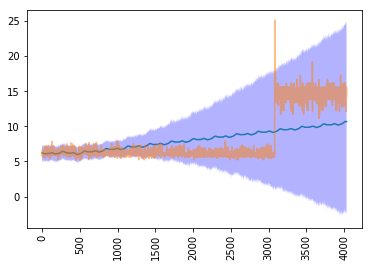

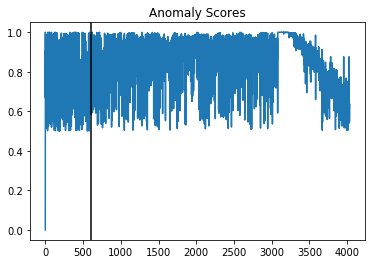

Time:  12.300942182540894


['anomaly_scores/Prophet/rds_cpu_utilization_cc0c53']

In [8]:
save_path = "anomaly_scores/Prophet/" + dataset_name
output_dict = ad.facebook_prophet(gaussian_window_size=gaussian_window_size, 
                                  changepoint_prior_scale=.2,
                                  step_size=100,
                                  plot_forecast=True,
                                  plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# HTM

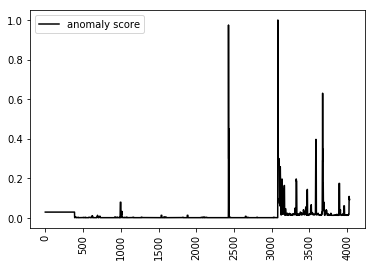

Time:  23.05


['anomaly_scores/HTM/rds_cpu_utilization_cc0c53']

In [9]:
htm_results_path = "htm_studio_results/" + "htm_results_" + dataset_name + "_value.csv"

htm_results = pd.read_csv(htm_results_path, header=0)

plt.plot(htm_results["raw_anomaly_score"], color="black", label="anomaly score")
plt.legend()
plt.xticks(rotation=90)
plt.show()

anomaly_scores = np.nan_to_num(htm_results["raw_anomaly_score"].values)

save_path = "anomaly_scores/HTM/" + dataset_name
print("Time: ", 23.05)
output_dict = {"Anomaly Scores": anomaly_scores, "Time": 23.05}
joblib.dump(output_dict, save_path)

# windowed gaussian

In [10]:
# optimization step
step_sizes = [100, 200, 300, 400, 500]

opt_dict = {}

for step_size in step_sizes:
    print("Step size: ", step_size)
    output_dict = ad.windowed_gaussian(gaussian_window_size=gaussian_window_size, 
                                       step_size = step_size, 
                                       optimize=True,
                                       plot_anomaly_score=False)
    print("MSE: ", output_dict["MSE"])
    opt_dict[step_size] = output_dict["MSE"]

best_step_size = min(opt_dict, key=opt_dict.get)
print("\nbest step size: ", best_step_size)

Step size:  100
MSE:  0.20465115472524334
Step size:  200
MSE:  0.20465115472524334
Step size:  300
MSE:  0.20465115472524334
Step size:  400
MSE:  0.20465115472524334
Step size:  500
MSE:  0.20465115472524334

best step size:  100


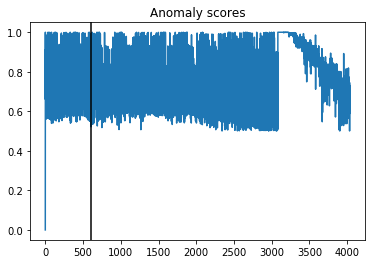

Time:  0.1420738697052002


['anomaly_scores/windowed_gaussian/rds_cpu_utilization_cc0c53']

In [11]:
save_path = "anomaly_scores/windowed_gaussian/" + dataset_name

output_dict = ad.windowed_gaussian(gaussian_window_size=gaussian_window_size, 
                                   step_size = best_step_size, 
                                   plot_anomaly_score=True)

print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# HOTSAX

In [12]:
# only need one window size

# save_path = "anomaly_scores/hotsax/" + dataset_name
# output_dict = ad.hotsax(win_size=50, num_discords=int((.2/100) * ad.get_length()),
#                a_size=3, paa_size=3, z_threshold=0.01,
#                plot_anomaly_score=True)
# print("Time: ", output_dict["Time"])
# joblib.dump(output_dict, save_path)

In [13]:
# no twitter bc no seasonality
# no stl bc no seasonality
# no anomalous bc no seasonality